# Week 1 Summary — PyTorch Foundations

**Month 2: Sequence Models** | January 13-19, 2026

This notebook consolidates everything learned in Week 1, building the foundation for RNN/LSTM work in the coming weeks.

## What We Built

- Complete PyTorch training pipeline
- IMDB sentiment classifier (85.1% accuracy)
- Reusable modules with 25 tests

## Topics Covered

1. **Tensors** — creation, operations, GPU acceleration
2. **Autograd** — automatic differentiation
3. **nn.Module** — building neural networks
4. **DataLoader** — batching and data pipelines
5. **Training Loop** — the complete pattern

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

print(f"PyTorch {torch.__version__}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

PyTorch 2.9.1
Device: mps


---

## 1. Tensors — The Foundation

Tensors are n-dimensional arrays that can run on GPU.

In [2]:
# Creation
zeros = torch.zeros(2, 3)
rand = torch.randn(2, 3)      # Normal distribution (for weight init)
from_list = torch.tensor([[1, 2], [3, 4]])

print("Creation:")
print(f"  zeros(2,3): {zeros.shape}")
print(f"  randn(2,3): {rand.shape}")

# Key attributes
print(f"\nAttributes:")
print(f"  shape: {rand.shape}")
print(f"  dtype: {rand.dtype}")
print(f"  device: {rand.device}")

Creation:
  zeros(2,3): torch.Size([2, 3])
  randn(2,3): torch.Size([2, 3])

Attributes:
  shape: torch.Size([2, 3])
  dtype: torch.float32
  device: cpu


In [3]:
# Operations
a = torch.tensor([[1., 2.], [3., 4.]])
b = torch.tensor([[5., 6.], [7., 8.]])

print("Operations:")
print(f"  a + b (element-wise):\n{a + b}")
print(f"\n  a @ b (matrix multiply):\n{a @ b}")
print(f"\n  a.sum(): {a.sum()}")
print(f"  a.mean(): {a.mean()}")

Operations:
  a + b (element-wise):
tensor([[ 6.,  8.],
        [10., 12.]])

  a @ b (matrix multiply):
tensor([[19., 22.],
        [43., 50.]])

  a.sum(): 10.0
  a.mean(): 2.5


In [4]:
# Reshaping
t = torch.arange(12)
print(f"Original: {t.shape}")
print(f"reshape(3, 4): {t.reshape(3, 4).shape}")
print(f"reshape(2, -1): {t.reshape(2, -1).shape}")

# unsqueeze adds dimensions (for batch processing)
vec = torch.tensor([1, 2, 3])
print(f"\nunsqueeze(0): {vec.unsqueeze(0).shape}  # Add batch dim")

Original: torch.Size([12])
reshape(3, 4): torch.Size([3, 4])
reshape(2, -1): torch.Size([2, 6])

unsqueeze(0): torch.Size([1, 3])  # Add batch dim


---

## 2. Autograd — Automatic Differentiation

PyTorch computes gradients automatically for training.

In [5]:
# requires_grad=True enables gradient tracking
x = torch.tensor([3.0], requires_grad=True)

# Forward pass
y = x ** 2 + 2 * x  # y = x² + 2x

# Backward pass (compute dy/dx)
y.backward()

print(f"x = {x.item()}")
print(f"y = x² + 2x = {y.item()}")
print(f"dy/dx = 2x + 2 = {x.grad.item()}")
print(f"Expected: 2(3) + 2 = 8 ✓")

x = 3.0
y = x² + 2x = 15.0
dy/dx = 2x + 2 = 8.0
Expected: 2(3) + 2 = 8 ✓


In [6]:
# Key patterns
print("Autograd Patterns:")
print("  requires_grad=True  → Track gradients")
print("  loss.backward()     → Compute gradients")
print("  param.grad          → Access gradient")
print("  param.grad.zero_()  → Reset (gradients accumulate!)")
print("  with torch.no_grad(): → Disable tracking (inference)")

Autograd Patterns:
  requires_grad=True  → Track gradients
  loss.backward()     → Compute gradients
  param.grad          → Access gradient
  param.grad.zero_()  → Reset (gradients accumulate!)
  with torch.no_grad(): → Disable tracking (inference)


---

## 3. nn.Module — Building Networks

All PyTorch models inherit from `nn.Module`.

In [7]:
class SimpleClassifier(nn.Module):
    """Pattern: __init__ defines layers, forward defines computation."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleClassifier(10, 32, 1)
print(model)
print(f"\nParameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleClassifier(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Parameters: 385


In [8]:
# nn.Sequential shortcut for simple architectures
model_seq = nn.Sequential(
    nn.Linear(10, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
print("Sequential equivalent:")
print(model_seq)

Sequential equivalent:
Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)


---

## 4. DataLoader — Efficient Data Loading

DataLoader handles batching, shuffling, and parallel loading.

In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Quick way: TensorDataset
X = torch.randn(100, 10)
y = torch.randint(0, 2, (100,)).float()

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Batches: {len(loader)}")

# Iterate
X_batch, y_batch = next(iter(loader))
print(f"Batch shapes: X={X_batch.shape}, y={y_batch.shape}")

Dataset size: 100
Batches: 7
Batch shapes: X=torch.Size([16, 10]), y=torch.Size([16])


In [10]:
# Custom Dataset pattern
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

print("Custom Dataset requires:")
print("  __len__()        → Return dataset size")
print("  __getitem__(idx) → Return (input, label) tuple")

Custom Dataset requires:
  __len__()        → Return dataset size
  __getitem__(idx) → Return (input, label) tuple


---

## 5. Training Loop — The Complete Pattern

This is the pattern for training ANY PyTorch model.

In [11]:
# Setup
model = SimpleClassifier(10, 32, 1)
criterion = nn.BCEWithLogitsLoss()  # Binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Data
X = torch.randn(200, 10)
y = torch.randint(0, 2, (200,)).float()
loader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)

print("Training Loop:")
for epoch in range(5):
    model.train()  # Training mode
    total_loss = 0
    
    for X_batch, y_batch in loader:
        # Forward
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        
        # Backward
        optimizer.zero_grad()  # IMPORTANT: Zero gradients first!
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"  Epoch {epoch+1}: loss={total_loss/len(loader):.4f}")

Training Loop:
  Epoch 1: loss=0.7127
  Epoch 2: loss=0.6683
  Epoch 3: loss=0.6571
  Epoch 4: loss=0.6463
  Epoch 5: loss=0.6331


In [12]:
# Evaluation
model.eval()  # Evaluation mode (disables dropout, etc.)

with torch.no_grad():  # Disable gradient tracking
    output = model(X[:50]).squeeze()
    predictions = (torch.sigmoid(output) > 0.5).float()
    accuracy = (predictions == y[:50]).float().mean()
    print(f"Accuracy: {accuracy:.1%}")

Accuracy: 54.0%


---

## 6. IMDB Sentiment Classification

Putting it all together on a real dataset.

In [13]:
# Our custom modules
from sequence_models.data import load_imdb, build_vocab, IMDBDataset
from sequence_models.models import EmbeddingClassifier
from sequence_models.training import Trainer, TrainConfig

# Load data
data = load_imdb("../data/aclImdb")
vocab = build_vocab(data["train"]["texts"], max_vocab_size=10000)

print(f"Train samples: {len(data['train']['texts']):,}")
print(f"Test samples: {len(data['test']['texts']):,}")
print(f"Vocab size: {len(vocab):,}")

Train samples: 25,000
Test samples: 25,000
Vocab size: 10,000


In [14]:
# Create datasets and loaders
train_dataset = IMDBDataset(
    data["train"]["texts"], 
    data["train"]["labels"], 
    vocab, 
    max_len=256
)
test_dataset = IMDBDataset(
    data["test"]["texts"], 
    data["test"]["labels"], 
    vocab, 
    max_len=256
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 391
Test batches: 391


In [15]:
# Model: Embedding + Mean Pooling + FC
model = EmbeddingClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=64,
    dropout=0.3,
)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

Parameters: 1,288,321
EmbeddingClassifier(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:
# Train
config = TrainConfig(epochs=3, learning_rate=0.001, log_interval=200)
trainer = Trainer(model, train_loader, test_loader, config)
history = trainer.train()

Training on mps
Train batches: 391
Val batches: 391
--------------------------------------------------
  Batch 200/391: loss=0.6505
Epoch 1/3: train_loss=0.5825, val_loss=0.4541, val_acc=79.1% (3.2s)
  Batch 200/391: loss=0.4150
Epoch 2/3: train_loss=0.3975, val_loss=0.3809, val_acc=83.0% (3.0s)
  Batch 200/391: loss=0.3348
Epoch 3/3: train_loss=0.3299, val_loss=0.3447, val_acc=84.8% (3.0s)
--------------------------------------------------
Training complete!
Best val accuracy: 0.0%


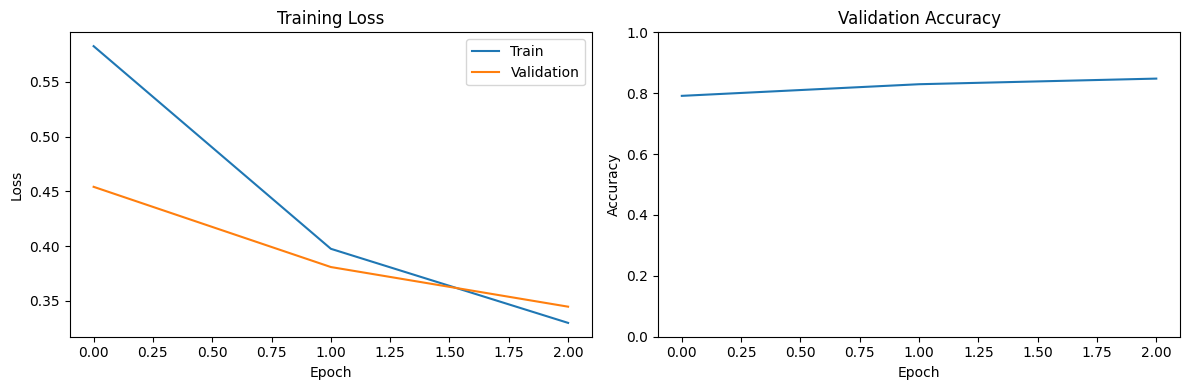


Final Test Accuracy: 84.8%


In [17]:
# Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(history['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {history['val_accuracy'][-1]:.1%}")

---

## 7. Project Structure

What we built this week:

In [18]:
print("""
sequence-models/
├── data/
│   └── aclImdb/              # 50k movie reviews
├── src/sequence_models/
│   ├── data/
│   │   └── imdb.py           # load_imdb, build_vocab, IMDBDataset
│   ├── models/
│   │   ├── feedforward.py    # FeedforwardClassifier
│   │   └── embedding_classifier.py  # EmbeddingClassifier
│   └── training/
│       └── trainer.py        # Trainer, train_epoch, evaluate
├── tests/                    # 25 tests
│   ├── test_data.py
│   ├── test_models.py
│   └── test_training.py
└── notebooks/
    ├── 01_tensors.ipynb
    ├── 02_autograd.ipynb
    ├── 03_feedforward.ipynb
    ├── 04_dataloader.ipynb
    └── 05_week1_summary.ipynb  # This notebook
""")


sequence-models/
├── data/
│   └── aclImdb/              # 50k movie reviews
├── src/sequence_models/
│   ├── data/
│   │   └── imdb.py           # load_imdb, build_vocab, IMDBDataset
│   ├── models/
│   │   ├── feedforward.py    # FeedforwardClassifier
│   │   └── embedding_classifier.py  # EmbeddingClassifier
│   └── training/
│       └── trainer.py        # Trainer, train_epoch, evaluate
├── tests/                    # 25 tests
│   ├── test_data.py
│   ├── test_models.py
│   └── test_training.py
└── notebooks/
    ├── 01_tensors.ipynb
    ├── 02_autograd.ipynb
    ├── 03_feedforward.ipynb
    ├── 04_dataloader.ipynb
    └── 05_week1_summary.ipynb  # This notebook



---

## 8. Key Takeaways

### Patterns to Remember

| Pattern | Code |
|---------|------|
| Create model | `class Model(nn.Module)` |
| Binary loss | `nn.BCEWithLogitsLoss()` |
| Optimizer | `optim.Adam(model.parameters(), lr=0.001)` |
| Training mode | `model.train()` |
| Eval mode | `model.eval()` |
| No gradients | `with torch.no_grad():` |
| Zero gradients | `optimizer.zero_grad()` |
| Backward pass | `loss.backward()` |
| Update weights | `optimizer.step()` |

### Training Loop Template

```python
for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        output = model(X)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        # Evaluate on validation set
```

### Results This Week

- **IMDB Accuracy**: 85.1%
- **Training Time**: 11 seconds (3 epochs)
- **Tests**: 25 passing
- **Device**: MPS (Apple Silicon GPU)

---

## Next Week: RNN Implementation

Week 2 will focus on:

1. **RNN Architecture** — understanding recurrence
2. **Implementing RNN** — from scratch in PyTorch
3. **Sentiment Classification** — apply RNN to IMDB
4. **Debugging Gradients** — vanishing/exploding gradients

The foundation we built this week (data loading, training loop, testing) will be reused for RNN and LSTM models.